# FBA with E. coli mutants

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import cobra, requests, os

# Functions

In [2]:
def float_convert(x):
    try:
        y = float(x)
    except:
        y = None
    return y

# Load

In [3]:
"""TnSeq data"""
# Skip these cols
skip_cols = ['orgId', 'locusId', 'sysName', 'desc']
tnseq = pd.read_csv('ecoli_tnseq.tsv', '\t', index_col='geneName')
tnseq = tnseq[[c for c in tnseq if c not in skip_cols]]

# Metadata
md = pd.read_csv('ecoli_md.tsv', '\t')
md['Sample'] = md[['expName', 'expDesc']].apply(lambda x: ' '.join(x), 1)
md['concentration_1'] = md.concentration_1.apply(float_convert)
md['condition'] = md[['aerobic', 'condition_1', 'condition_2']].astype(str).apply(lambda x: '_'.join(x), 1)

"""Media"""
# LB Media
media_df = pd.read_csv('kb_media.2770.tsv', '\t')

"""Model"""
model = cobra.io.read_sbml_model('ecoli_model.xml')

model

Name,iJO1366
Memory address,0x02b1e21ec7c70
Number of metabolites,1805
Number of reactions,2583
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


# Define media

In [80]:
"""Translate media components from SEED to BIGG"""
# Get SEED <-> BIGG mappings
aliases = pd.read_csv('https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/Aliases/Unique_ModelSEED_Compound_Aliases.txt', '\t')
# Subset to LB media components and extract BIGG names
# Add '_e' to indicate external concentration (# all([m.id.endswith('_e') for m in model.metabolites if m.compartment == 'e']) ==> True)
bigg_components = list(aliases[aliases.Source.eq('BiGG') & aliases['ModelSEED ID'].isin(media_df.compounds.unique())]['External ID'].unique() + '_e')

# Manually add misnamed
# Any components missing
#### model_ext_metabolites = [m.id for m in model.metabolites if m.compartment == 'e']
#### missing_bigg = [c.strip('_e') for c in bigg_components if c not in model_ext_metabolites]
## No external riboflavin, hydroxide, ammonia, folate, thiamin monophosphate, arsenate, or chromate
misnamed = ['cys__L_e']

bigg_components.extend(misnamed)

"""Define media in COBRA"""
### Source: https://cobrapy.readthedocs.io/en/latest/media.html
# Get LB media metabolite objects
lb_metabs = [m for m in model.metabolites if m.id in bigg_components]
# Get exchange reactions associate with lb media metabolites
media_exchange_reactions = [r.id for r in model.exchanges if any(m in r.metabolites for m in lb_metabs)]

"""Get media supplements"""
# Media supplements
supp_names = md[md.media.eq('LB')].condition_1.str.lower().dropna().unique()

# Get all BIGG metabolites
all_bigg_metabs = pd.DataFrame(requests.get('http://bigg.ucsd.edu/api/v2/universal/metabolites/').json()['results'])

# Supplemental metabolites that could be scraped
supp_bigg_metab_names = all_bigg_metabs[all_bigg_metabs.name.str.lower().isin(supp_names)].bigg_id + '_e'

# Exchange reactions found in model
supp_exchange_reactions = [r.id for r in model.exchanges if any(m in [mr.id for mr in r.metabolites.keys()] for m in supp_bigg_metab_names)]

"""Create dictionaries for all available conditions"""
conditions = {}
# Aerobic vs. anaerobic
for o2, aer_name in zip([100, 0], ['aerobic', 'anaerobic']):
    # Each supplemental reaction (starting with no supp)
    for sup in [None] + supp_exchange_reactions:
        # Assign bound to base media
        media_dict = {m: 100 for m in media_exchange_reactions}
        # Assign aerobicity
        media_dict['EX_o2_e'] = o2
        # Add supplement
        if sup:
            media_dict[sup] = 100
            sup_name = sup
        else:
            sup_name = 'lb'
        # Save
        condition_name = '_'.join([aer_name, sup_name])
        conditions[condition_name] = media_dict
conditions.keys()

dict_keys(['aerobic_lb', 'aerobic_EX_cm_e', 'aerobic_EX_lys__L_e', 'aerobic_EX_dmso_e', 'anaerobic_lb', 'anaerobic_EX_cm_e', 'anaerobic_EX_lys__L_e', 'anaerobic_EX_dmso_e'])

# Run FBA on each condition with WT and knockouts

In [81]:
"""Get list of mutated genes"""
genes = [g for g in model.genes if g.name in tnseq.index] # Missing about ~300 genes
geneid2name = {g.id: g.name for g in genes}

"""Run FBA for each mutant in each condition"""
data = []
for condition, media in conditions.items():
    # Set media for model
    model.medium = media
    
    # Get growth rate for WT
    wt_growth = model.optimize().objective_value
    
    # Perform knock out on tnseq genes
    kos = cobra.flux_analysis.single_gene_deletion(model, genes)
    kos['gene'] = kos.ids.apply(lambda x: list(x)[0]).map(geneid2name)
    results = kos.set_index('gene').growth.rename(condition)
    results['wildtype'] = wt_growth
    
    # Save 
    data.append(results)
fba_df = pd.concat(data, 1)
# Save
fba_df.to_csv('fba_results/ecoli_fba.csv')

# Normalize
fba_norm = fba_df/fba_df.loc['wildtype']
fba_df.head()

,aerobic_lb,aerobic_EX_cm_e,aerobic_EX_lys__L_e,aerobic_EX_dmso_e,anaerobic_lb,anaerobic_EX_cm_e,anaerobic_EX_lys__L_e,anaerobic_EX_dmso_e
hcaB,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
tdcC,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
sapD,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
ugd,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
fpr,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444


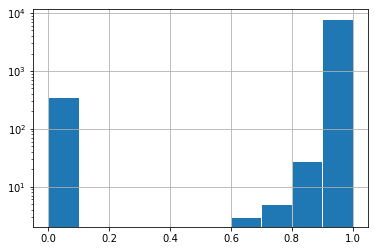

In [20]:
"""Distribution of normalized growth rates"""
fba_norm.stack().hist(ec='w')
plt.yscale('log')
plt.show()

**Overwhelmingly no effect to fitness**

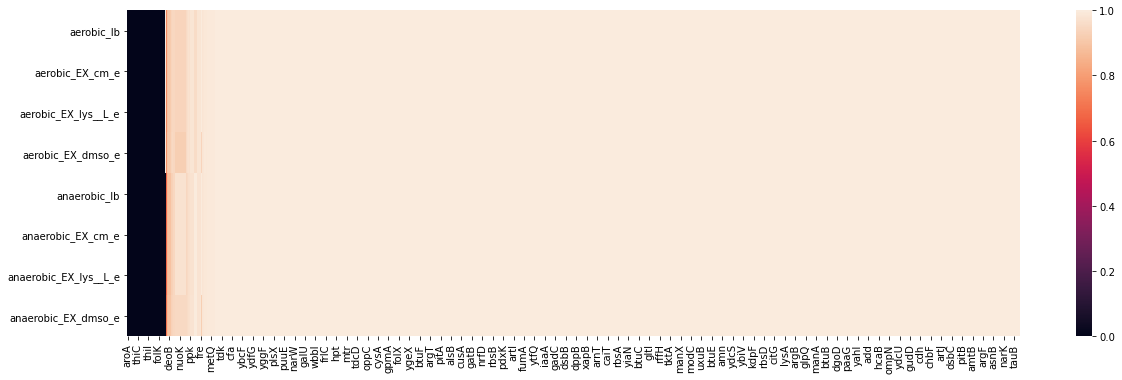

In [50]:
"""Normalized fitness of all mutants"""
plt.figure(figsize=(20, 6))
order = fba_norm.mean(1).sort_values().index
sns.heatmap(fba_norm.reindex(order).T, cmap='rocket')
plt.show()

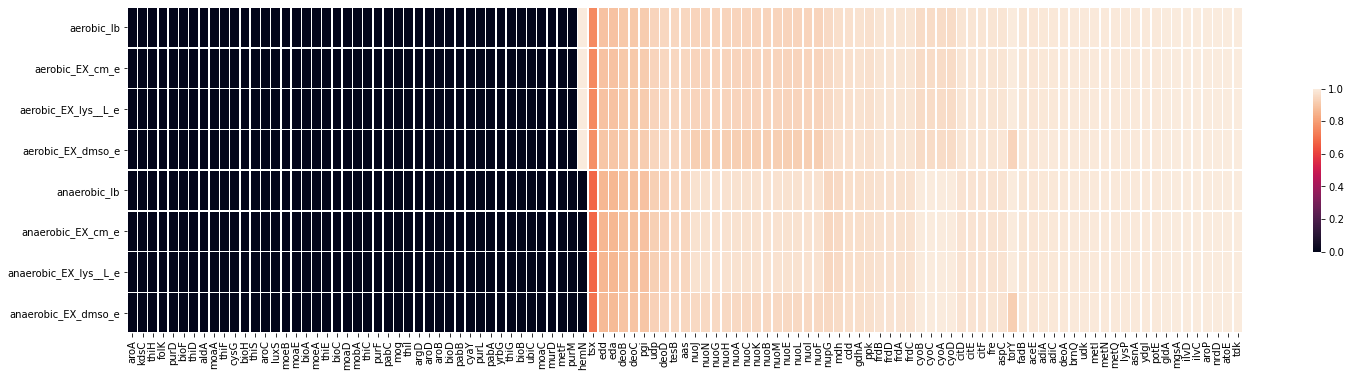

In [51]:
"""Heatmap of <1"""
plt.figure(figsize=(25, 6))
fba_effect = fba_norm[fba_norm.round(4).lt(1).any(1)]
order = fba_effect.mean(1).sort_values().index
sns.heatmap(fba_effect.reindex(order).T, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()